In [1]:
def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)       
    
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu),stddev=1.0)
    return mu + tf.exp(log_var / 2) * eps

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))  
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 3
    size = height * width
    
    for i in range(mb_size):
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C))/(4. * (channels ** 2) * (size ** 2))*3e-1)
    
    return loss_temp

def claps_loss(x):
    z_d_gen=backend.batch_flatten(x)          
    nom = tf.matmul(z_d_gen, tf.transpose(z_d_gen, perm=[1, 0]))
    denom = tf.sqrt(tf.reduce_sum(tf.square(z_d_gen), reduction_indices=[1], keep_dims=True))
    pt = tf.square(tf.transpose((nom / denom), (1, 0)) / denom)
    pt = pt - tf.diag(tf.diag_part(pt))
    pulling_term = tf.reduce_sum(pt) / (mb_size * (mb_size - 1))*4e3
    
    return pulling_term

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data
import scipy.io as sio
from keras import backend
from keras.models import Model
%matplotlib inline

images = np.array(sio.loadmat('alloy_mat/X_train.mat')['X_train'],dtype='float32')
images=images[0:10000]

mb_size = 100
z_dim = 10
X_dim = images.shape[1]
h_dim_2 = 100
h_dim_1 = 1000
height = 40
width = 40

c = 0
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(40, 40), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim_1]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim_1]))

Q_W2 = tf.Variable(xavier_init([h_dim_1, h_dim_2]))
Q_b2 = tf.Variable(tf.zeros(shape=[h_dim_2]))

Q_W3_mu = tf.Variable(xavier_init([h_dim_2, z_dim]))
Q_b3_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W3_sigma = tf.Variable(xavier_init([h_dim_2, z_dim]))
Q_b3_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
    h1 = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    h2 = tf.nn.relu(tf.matmul(h1, Q_W2) + Q_b2)
    z_mu = tf.matmul(h2, Q_W3_mu) + Q_b3_mu
    z_logvar = tf.matmul(h2, Q_W3_sigma) + Q_b3_sigma
    return z_mu, z_logvar


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim_2]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim_2]))

P_W2 = tf.Variable(xavier_init([h_dim_2, h_dim_1]))
P_b2 = tf.Variable(tf.zeros(shape=[h_dim_1]))

P_W3 = tf.Variable(xavier_init([h_dim_1, X_dim]))
P_b3 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z):
    h2 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h1 = tf.nn.relu(tf.matmul(h2, P_W2) + P_b2)
    logits = tf.matmul(h1, P_W3) + P_b3
    prob = tf.nn.sigmoid(logits)
    return prob


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)


Using TensorFlow backend.


In [3]:
style_array = np.zeros([len(images),height,width,3])
style_array[:,:,:,0]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,1]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,2]=(images.reshape(len(images),height,width))*1
print(style_array.shape)

(10000, 40, 40, 3)


In [4]:
######## weights & bias loaading ########
import h5py
f = h5py.File('weights_VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys()

vgg16_weights=[]
vgg16_bias=[]
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue

W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))
W_conv6 = (tf.constant(vgg16_weights[5]))
W_conv7 = (tf.constant(vgg16_weights[6]))
W_conv8 = (tf.constant(vgg16_weights[7]))
W_conv9 = (tf.constant(vgg16_weights[8]))
W_conv10= (tf.constant(vgg16_weights[9]))
W_conv11= (tf.constant(vgg16_weights[10]))
W_conv12= (tf.constant(vgg16_weights[11]))
W_conv13= (tf.constant(vgg16_weights[12]))

b_conv1 = tf.reshape(tf.constant(vgg16_bias[0]),[-1])
b_conv2 = tf.reshape(tf.constant(vgg16_bias[1]),[-1])
b_conv3 = tf.reshape(tf.constant(vgg16_bias[2]),[-1])
b_conv4 = tf.reshape(tf.constant(vgg16_bias[3]),[-1])
b_conv5 = tf.reshape(tf.constant(vgg16_bias[4]),[-1])
b_conv6 = tf.reshape(tf.constant(vgg16_bias[5]),[-1])
b_conv7 = tf.reshape(tf.constant(vgg16_bias[6]),[-1])
b_conv8 = tf.reshape(tf.constant(vgg16_bias[7]),[-1])
b_conv9 = tf.reshape(tf.constant(vgg16_bias[8]),[-1])
b_conv10 = tf.reshape(tf.constant(vgg16_bias[9]),[-1])
b_conv11 = tf.reshape(tf.constant(vgg16_bias[10]),[-1])
b_conv12 = tf.reshape(tf.constant(vgg16_bias[11]),[-1])
b_conv13 = tf.reshape(tf.constant(vgg16_bias[12]),[-1])

In [5]:
######## style transfer ########
combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*1
combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

In [6]:
######### block 1 ########
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

conv_out4 = conv2d(conv_out3, W_conv4, stride=1, padding='SAME')
conv_out4 = tf.nn.bias_add(conv_out4, b_conv4)
conv_out4 = tf.nn.relu(conv_out4)
conv_out4 = max_pool(conv_out4, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5 = conv2d(conv_out4, W_conv5, stride=1, padding='SAME')
conv_out5 = tf.nn.bias_add(conv_out5, b_conv5)
conv_out5 = tf.nn.relu(conv_out5)

conv_out6 = conv2d(conv_out5, W_conv6, stride=1, padding='SAME')
conv_out6 = tf.nn.bias_add(conv_out6, b_conv6)
conv_out6 = tf.nn.relu(conv_out6)

conv_out7 = conv2d(conv_out6, W_conv7, stride=1, padding='SAME')
conv_out7 = tf.nn.bias_add(conv_out7, b_conv7)
conv_out7 = tf.nn.relu(conv_out7)
conv_out7 = max_pool(conv_out7, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8 = conv2d(conv_out7, W_conv8, stride=1, padding='SAME')
conv_out8 = tf.nn.bias_add(conv_out8, b_conv8)
conv_out8 = tf.nn.relu(conv_out8)

conv_out9 = conv2d(conv_out8, W_conv9, stride=1, padding='SAME')
conv_out9 = tf.nn.bias_add(conv_out9, b_conv9)
conv_out9 = tf.nn.relu(conv_out9)

conv_out10= conv2d(conv_out9, W_conv10, stride=1, padding='SAME')
conv_out10= tf.nn.bias_add(conv_out10, b_conv10)
conv_out10= tf.nn.relu(conv_out10)
conv_out10 = max_pool(conv_out10, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11= conv2d(conv_out10, W_conv11, stride=1, padding='SAME')
conv_out11= tf.nn.bias_add(conv_out11, b_conv11)
conv_out11= tf.nn.relu(conv_out11)

conv_out12= conv2d(conv_out11, W_conv12, stride=1, padding='SAME')
conv_out12= tf.nn.bias_add(conv_out12, b_conv12)
conv_out12= tf.nn.relu(conv_out12)

conv_out13= conv2d(conv_out12, W_conv13, stride=1, padding='SAME')
conv_out13= tf.nn.bias_add(conv_out13, b_conv12)
conv_out13= tf.nn.relu(conv_out13)

In [7]:
######### block 1 ########
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

conv_out4_S = conv2d(conv_out3_S, W_conv4, stride=1, padding='SAME')
conv_out4_S = tf.nn.bias_add(conv_out4_S, b_conv4)
conv_out4_S = tf.nn.relu(conv_out4_S)
conv_out4_S = max_pool(conv_out4_S, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5_S = conv2d(conv_out4_S, W_conv5, stride=1, padding='SAME')
conv_out5_S = tf.nn.bias_add(conv_out5_S, b_conv5)
conv_out5_S = tf.nn.relu(conv_out5_S)

conv_out6_S = conv2d(conv_out5_S, W_conv6, stride=1, padding='SAME')
conv_out6_S = tf.nn.bias_add(conv_out6_S, b_conv6)
conv_out6_S = tf.nn.relu(conv_out6_S)

conv_out7_S = conv2d(conv_out6_S, W_conv7, stride=1, padding='SAME')
conv_out7_S = tf.nn.bias_add(conv_out7_S, b_conv7)
conv_out7_S = tf.nn.relu(conv_out7_S)
conv_out7_S = max_pool(conv_out7_S, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8_S = conv2d(conv_out7_S, W_conv8, stride=1, padding='SAME')
conv_out8_S = tf.nn.bias_add(conv_out8_S, b_conv8)
conv_out8_S = tf.nn.relu(conv_out8_S)

conv_out9_S = conv2d(conv_out8_S, W_conv9, stride=1, padding='SAME')
conv_out9_S = tf.nn.bias_add(conv_out9_S, b_conv9)
conv_out9_S = tf.nn.relu(conv_out9_S)

conv_out10_S= conv2d(conv_out9_S, W_conv10, stride=1, padding='SAME')
conv_out10_S= tf.nn.bias_add(conv_out10_S, b_conv10)
conv_out10_S= tf.nn.relu(conv_out10_S)
conv_out10_S= max_pool(conv_out10_S, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11_S= conv2d(conv_out10_S, W_conv11, stride=1, padding='SAME')
conv_out11_S= tf.nn.bias_add(conv_out11_S, b_conv11)
conv_out11_S= tf.nn.relu(conv_out11_S)

conv_out12_S= conv2d(conv_out11_S, W_conv12, stride=1, padding='SAME')
conv_out12_S= tf.nn.bias_add(conv_out12_S, b_conv12)
conv_out12_S= tf.nn.relu(conv_out12_S)

conv_out13_S= conv2d(conv_out12_S, W_conv13, stride=1, padding='SAME')
conv_out13_S= tf.nn.bias_add(conv_out13_S, b_conv13)
conv_out13_S= tf.nn.relu(conv_out13_S)

In [8]:
sl1 = style_loss(conv_out2_S,conv_out2)
sl2 = style_loss(conv_out4_S,conv_out4)
sl3 = style_loss(conv_out1_S,conv_out1)
sl4 = style_loss(conv_out3_S,conv_out3)
sl_loss = sl1 + sl2 + sl3 + sl4


# # claps cost
cl1 = claps_loss(conv_out2)
cl2 = claps_loss(conv_out4)
cl3 = claps_loss(conv_out1)
cl4 = claps_loss(conv_out3)
cl_loss = cl1 + cl2 + cl3+cl4

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/1

# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))


# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss + sl_loss + cl_loss)

In [17]:
# import random
# solver = tf.train.AdamOptimizer().minimize(vae_loss)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# if not os.path.exists('out/'):
#     os.makedirs('out/')

# i = 0
# saver = tf.train.Saver()
# cl_E_store=[]
# sl_E_store=[]
# recon_E_store=[]
for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E,cl_E,sl_E = sess.run([solver, vae_loss, recon_loss, kl_loss, cl_loss, sl_loss],
                                                feed_dict={X: X_mb,
                                                           style_image: style_array_input.reshape(mb_size,40,40,3),
                                                           z: np.random.randn(mb_size, z_dim)})

    
    sl_E_store.append(sl_E)
    cl_E_store.append(cl_E)
    recon_E_store.append(recon_E)
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('Young_E:{}'.format(Young_E))
        print('cl_E:{}'.format(cl_E))
        print('sl_E:{}'.format(sl_E))
#         print('sl_E1:{}'.format(sl_E1))
#         print('sl_E2:{}'.format(sl_E2))
#         print('sl_E3:{}'.format(sl_E3))
#         print('sl_E4:{}'.format(sl_E4))
#         print('vl_E:{}'.format(vl_E))
        
        print()

Iter: 0
Loss: 10341.2099609
recon_E:17.5137138367
kl_E:32.1104850769
cl_E:7261.33789062
sl_E:3030.24780273
()
Iter: 100
Loss: 10305.9804688
recon_E:17.6370315552
kl_E:31.996427536
cl_E:7260.63232422
sl_E:2995.71484375
()
Iter: 200
Loss: 10299.9414062
recon_E:18.7129554749
kl_E:33.0964431763
cl_E:7334.97216797
sl_E:2913.16015625
()
Iter: 300
Loss: 10220.0507812
recon_E:17.6118621826
kl_E:32.3720092773
cl_E:7247.97900391
sl_E:2922.08789062
()
Iter: 400
Loss: 10195.9013672
recon_E:17.4761180878
kl_E:33.2936706543
cl_E:7254.39941406
sl_E:2890.73193359
()
Iter: 500
Loss: 10305.2519531
recon_E:18.8620147705
kl_E:31.9850063324
cl_E:7260.56396484
sl_E:2993.84057617
()
Iter: 600
Loss: 10126.2285156
recon_E:17.6052627563
kl_E:32.8370513916
cl_E:7361.17578125
sl_E:2714.61035156
()
Iter: 700
Loss: 10309.2246094
recon_E:17.2530593872
kl_E:32.723991394
cl_E:7380.74560547
sl_E:2878.50219727
()
Iter: 800
Loss: 10188.921875
recon_E:17.8610534668
kl_E:32.8097610474
cl_E:7270.49707031
sl_E:2867.75439453


In [ ]:
Q_W1 = tf.Variable(xavier_init([X_dim, h_dim_1]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim_1]))

Q_W2 = tf.Variable(xavier_init([h_dim_1, h_dim_2]))
Q_b2 = tf.Variable(tf.zeros(shape=[h_dim_2]))

Q_W3_mu = tf.Variable(xavier_init([h_dim_2, z_dim]))
Q_b3_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W3_sigma = tf.Variable(xavier_init([h_dim_2, z_dim]))
Q_b3_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
    h1 = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    h2 = tf.nn.relu(tf.matmul(h1, Q_W2) + Q_b2)
    z_mu = tf.matmul(h2, Q_W3_mu) + Q_b3_mu
    z_logvar = tf.matmul(h2, Q_W3_sigma) + Q_b3_sigma
    return z_mu, z_logvar


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim_2]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim_2]))

P_W2 = tf.Variable(xavier_init([h_dim_2, h_dim_1]))
P_b2 = tf.Variable(tf.zeros(shape=[h_dim_1]))

P_W3 = tf.Variable(xavier_init([h_dim_1, X_dim]))
P_b3 = tf.Variable(tf.zeros(shape=[X_dim]))

In [22]:
sio.savemat('tinghao/W1.mat',mdict={'W':sess.run(Q_W1)})
sio.savemat('tinghao/W2.mat',mdict={'W':sess.run(Q_W2)})
sio.savemat('tinghao/W3_1.mat',mdict={'W':sess.run(Q_W3_mu)})
sio.savemat('tinghao/W3_2.mat',mdict={'W':sess.run(Q_W3_sigma)})


sio.savemat('tinghao/deW1.mat',mdict={'W':sess.run(P_W1)})
sio.savemat('tinghao/deW2.mat',mdict={'W':sess.run(P_W2)})
sio.savemat('tinghao/deW3.mat',mdict={'W':sess.run(P_W3)})


sio.savemat('tinghao/b1.mat',mdict={'b':sess.run(Q_b1)})
sio.savemat('tinghao/b2.mat',mdict={'b':sess.run(Q_b2)})
sio.savemat('tinghao/b3_1.mat',mdict={'b':sess.run(Q_b3_mu)})
sio.savemat('tinghao/b3_2.mat',mdict={'b':sess.run(Q_b3_sigma)})


sio.savemat('tinghao/deb1.mat',mdict={'b':sess.run(P_b1)})
sio.savemat('tinghao/deb2.mat',mdict={'b':sess.run(P_b2)})
sio.savemat('tinghao/deb3.mat',mdict={'b':sess.run(P_b3)})


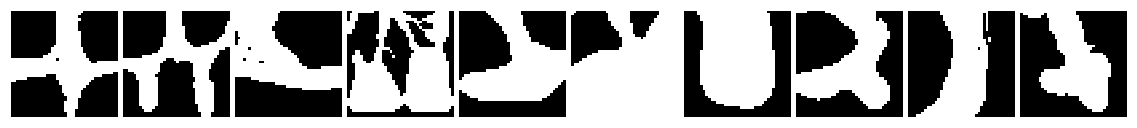

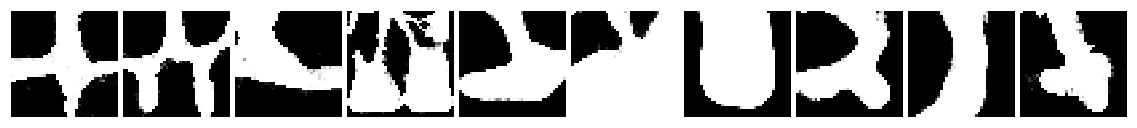

In [18]:
%matplotlib inline
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(40, 40), cmap='Greys_r')

X_mb = images[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb})

plot(images[0:10])
plot(recon[0:10])

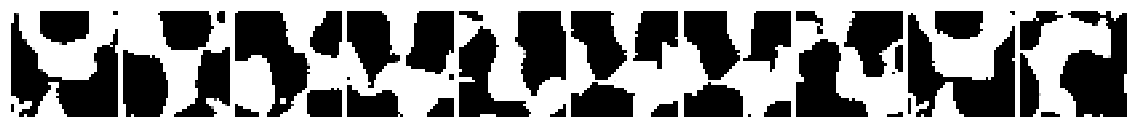

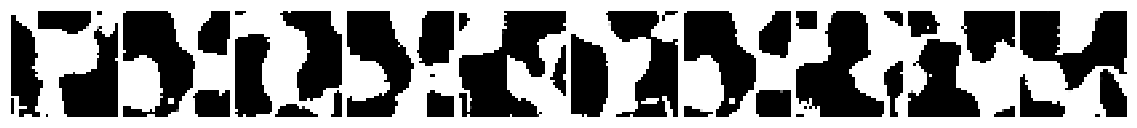

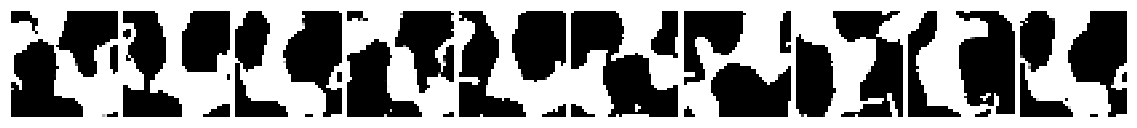

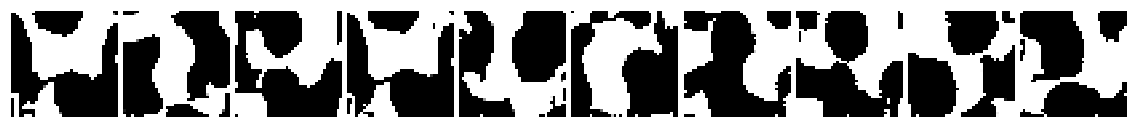

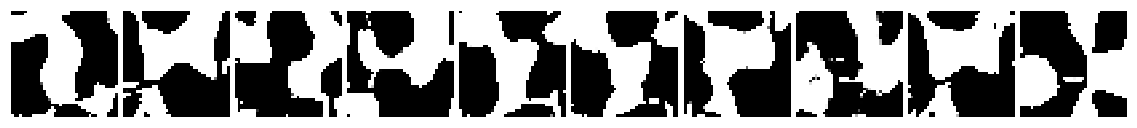

In [20]:
samples = sess.run(X_samples, feed_dict={X: X_mb,
                                         z: np.random.normal(0, 1, [mb_size, z_dim])})
for i in range(5):
    plot(samples[i*10:i*10+10])

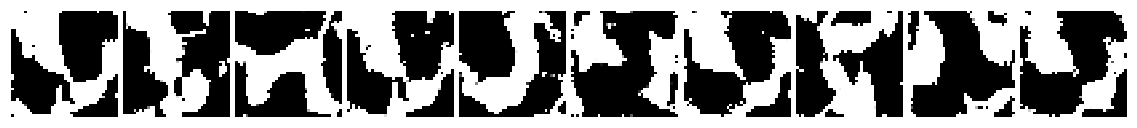

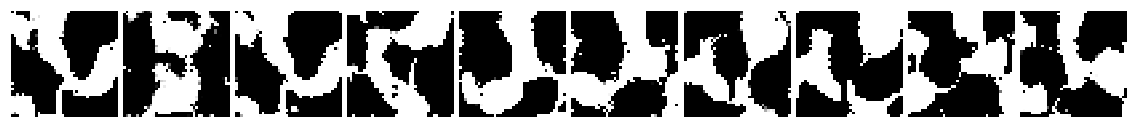

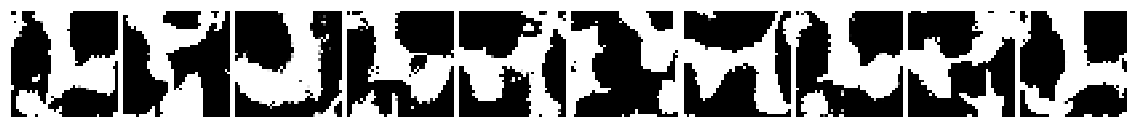

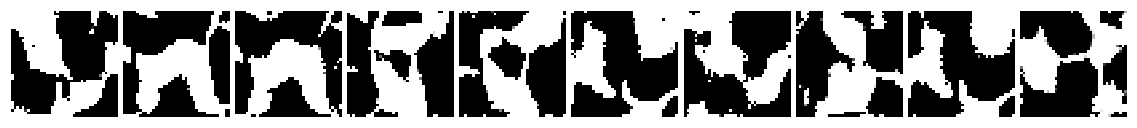

In [15]:
samples = sess.run(X_samples, feed_dict={X: X_mb,
                                         z: np.random.normal(0, 1, [mb_size, z_dim])})
for i in range(4):
    plot(samples[i*10:i*10+10])

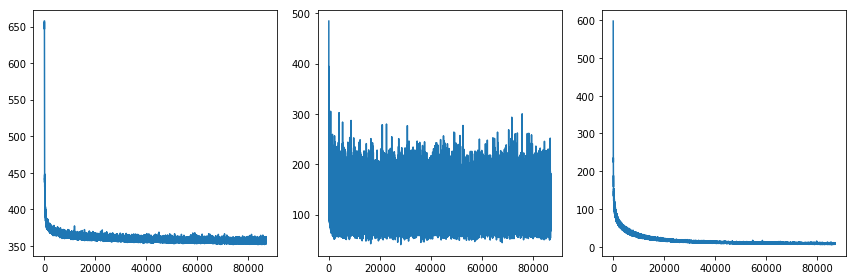

In [13]:
%matplotlib inline
# plt.plot(sl_E_store)
fig = plt.figure()
fig.set_size_inches(12,4)

ax1 = fig.add_subplot(131)
im1=ax1.plot(cl_E_store)

ax2 = fig.add_subplot(132)
im2=ax2.plot(sl_E_store)

ax3 = fig.add_subplot(133)
im3=ax3.plot(recon_E_store)

plt.tight_layout()
fig = plt.gcf()